# Neural Network

## Load Data

In [2]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [4]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [5]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [6]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l1_b, p_l2_w, p_l2_b):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l1_b = p_l1_b
        self.p_l2_w = p_l2_w
        self.p_l2_b = p_l2_b
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.GradientDescentOptimizer(0.003).minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None, 10], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l1_b = tf.Variable(self.p_l1_b, dtype=tf.float32, name='l1_b')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')
        self.l2_b = tf.Variable(self.p_l2_b, dtype=tf.float32, name='l2_b')

    def build(self):
        l1_a = tf.sigmoid(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        logits = tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b)
        return logits

In [7]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [8]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

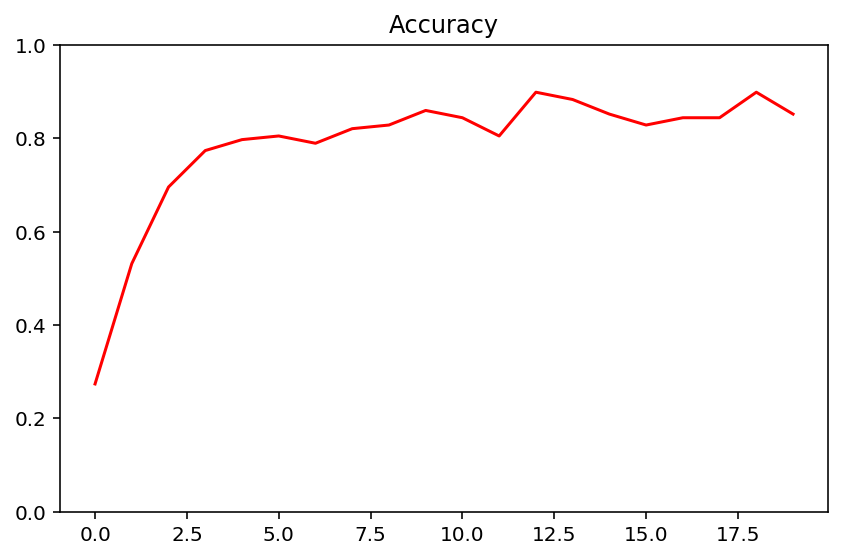

In [341]:
batch_size = 128
x_dim = 784
n_classes = 10
epochs = 20

with tf.Session() as sess:
    
    l1_w = [[truncated_normal() for _ in range(100)] for _ in range(x_dim)]
    l1_b = np.zeros(100)
    l2_w = [[truncated_normal() for _ in range(10)] for _ in range(100)]
    l2_b = np.zeros(10)

    net = Network(x_dim, n_classes, l1_w, l1_b, l2_w, l2_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        batch_num = mnist.train.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.train.next_batch(batch_size)
            train_batch = train_batch*2-1

            # Run optimizers
            feed_dict = {net.x:train_batch,
                         net.y:labels}
            _ = sess.run([net.optimizer], feed_dict=feed_dict)
            logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
            
        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [9]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [10]:
__DEBUG__ = False
batch_size = 64
x_dim = 784
n_classes = 10

In [11]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
    def generate(self):
        self.gene = {}
        # l1_w 
        self.gene[0] = np.random.randn(x_dim, 100)
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.random.randn(100, 10)
        # l2_b 
        self.gene[3] = np.random.randn(10)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          n_classes,
                          self.gene[0],
                          self.gene[1], 
                          self.gene[2], 
                          self.gene[3])
            sess.run(tf.global_variables_initializer())
            
            values = []
            batch_num = mnist.train.num_examples//batch_size
            for ii in range(batch_num):
                train_batch, labels = mnist.train.next_batch(batch_size)
                # Run optimizers
                feed_dict = {net.x: train_batch,
                             net.y: labels}
                values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent, recombination_probability=.5):
        child = {}
        child[0] = self.gene[0][:]
        child[1] = self.gene[1][:]
        child[2] = self.gene[2][:]
        child[3] = self.gene[3][:]
        
        for ii, g in enumerate(child[0]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[0][ii] = (g + parent.gene[0][ii])/2.
    
        for ii, g in enumerate(child[1]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[1][ii] = (g + parent.gene[1][ii])/2.
        
        for ii, g in enumerate(child[2]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[2][ii] = (g + parent.gene[2][ii])/2.
        
        for ii, g in enumerate(child[3]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[3][ii] = (g + parent.gene[3][ii])/2.
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate=.05):
        prob = np.random.sample()

        if prob <= mutation_rate:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              n_classes,
                              self.gene[0],
                              self.gene[1], 
                              self.gene[2], 
                              self.gene[3])
                sess.run(tf.global_variables_initializer())
                
                batch_num = mnist.train.num_examples//batch_size
                for ii in range(batch_num):
                    train_batch, labels = mnist.train.next_batch(batch_size)
                    # Run optimizers
                    feed_dict = {net.x: train_batch,
                                 net.y: labels}
                    _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = sess.run(net.l1_w)
                self.gene[1] = sess.run(net.l1_b)
                self.gene[2] = sess.run(net.l2_w)
                self.gene[3] = sess.run(net.l2_b)
        

In [12]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [15]:
# hypter-parameters
max_generations = 100
population_size = 20
mutation_rate = 1.

In [16]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual

1/20, Accuracy 0.10519135743379593
2/20, Accuracy 0.10348151624202728
3/20, Accuracy 0.08942084014415741
4/20, Accuracy 0.09740614145994186
5/20, Accuracy 0.09544164687395096
6/20, Accuracy 0.08436408638954163
7/20, Accuracy 0.1086656004190445
8/20, Accuracy 0.10353609174489975
9/20, Accuracy 0.11001164466142654
10/20, Accuracy 0.13624127209186554
11/20, Accuracy 0.11806970089673996
12/20, Accuracy 0.08929350972175598
13/20, Accuracy 0.09578724950551987
14/20, Accuracy 0.08270882070064545
15/20, Accuracy 0.11388605833053589
16/20, Accuracy 0.10710128396749496
17/20, Accuracy 0.10297220945358276
18/20, Accuracy 0.07157668471336365
19/20, Accuracy 0.08196303993463516
20/20, Accuracy 0.07073996216058731
Generation: 1/100, Solution accuracy: 0.13624127209186554
2/21, Accuracy 0.11364959180355072
3/21, Accuracy 0.11346769332885742
4/21, Accuracy 0.09971623867750168
5/21, Accuracy 0.1400974988937378
6/21, Accuracy 0.11232174187898636
7/21, Accuracy 0.10044383257627487
8/21, Accuracy 0.100389

17/21, Accuracy 0.1357683390378952
18/21, Accuracy 0.13458600640296936
19/21, Accuracy 0.13556824624538422
20/21, Accuracy 0.13618670403957367
21/21, Accuracy 0.13413125276565552
Generation: 11/100, Solution accuracy: 0.257694274187088
2/21, Accuracy 0.13744179904460907
3/21, Accuracy 0.13886059820652008
4/21, Accuracy 0.3607756197452545
5/21, Accuracy 0.1388060301542282
6/21, Accuracy 0.3424767255783081
7/21, Accuracy 0.13769644498825073
8/21, Accuracy 0.13915163278579712
9/21, Accuracy 0.13995197415351868
10/21, Accuracy 0.13840584456920624
11/21, Accuracy 0.13958817720413208
12/21, Accuracy 0.13753274083137512
13/21, Accuracy 0.13995197415351868
14/21, Accuracy 0.13840584456920624
15/21, Accuracy 0.13998836278915405
16/21, Accuracy 0.13716894388198853
17/21, Accuracy 0.13977007567882538
18/21, Accuracy 0.13836947083473206
19/21, Accuracy 0.13780558109283447
20/21, Accuracy 0.14053405821323395
21/21, Accuracy 0.13711437582969666
Generation: 12/100, Solution accuracy: 0.36077561974525

13/21, Accuracy 0.4003383219242096
14/21, Accuracy 0.4030667841434479
15/21, Accuracy 0.402812123298645
16/21, Accuracy 0.40235739946365356
17/21, Accuracy 0.4032304883003235
18/21, Accuracy 0.4027029871940613
19/21, Accuracy 0.4037579894065857
20/21, Accuracy 0.3979918658733368
21/21, Accuracy 0.40364885330200195
Generation: 22/100, Solution accuracy: 0.49041399359703064
2/21, Accuracy 0.4015570282936096
3/21, Accuracy 0.40455836057662964
4/21, Accuracy 0.40170255303382874
5/21, Accuracy 0.40312135219573975
6/21, Accuracy 0.40328505635261536
7/21, Accuracy 0.40204817056655884
8/21, Accuracy 0.4026120603084564
9/21, Accuracy 0.4045947194099426
10/21, Accuracy 0.40255749225616455
11/21, Accuracy 0.4024847149848938
12/21, Accuracy 0.4030667841434479
13/21, Accuracy 0.40288490056991577
14/21, Accuracy 0.4021391272544861
15/21, Accuracy 0.40439465641975403
16/21, Accuracy 0.4019753932952881
17/21, Accuracy 0.4033578336238861
18/21, Accuracy 0.4026848077774048
19/21, Accuracy 0.401738941669

9/21, Accuracy 0.42949649691581726
10/21, Accuracy 0.4281140863895416
11/21, Accuracy 0.4283687472343445
12/21, Accuracy 0.42862340807914734
13/21, Accuracy 0.4284960627555847
14/21, Accuracy 0.429805725812912
15/21, Accuracy 0.4310608208179474
16/21, Accuracy 0.42900538444519043
17/21, Accuracy 0.42700451612472534
18/21, Accuracy 0.43058788776397705
19/21, Accuracy 0.42678624391555786
20/21, Accuracy 0.42931461334228516
21/21, Accuracy 0.4286961555480957
Generation: 33/100, Solution accuracy: 0.5208090543746948
2/21, Accuracy 0.4288962483406067
3/21, Accuracy 0.4304969310760498
4/21, Accuracy 0.429605633020401
5/21, Accuracy 0.42736831307411194
6/21, Accuracy 0.4310426414012909
7/21, Accuracy 0.4268589913845062
8/21, Accuracy 0.430005818605423
9/21, Accuracy 0.42966020107269287
10/21, Accuracy 0.42755019664764404
11/21, Accuracy 0.42842331528663635
12/21, Accuracy 0.429569274187088
13/21, Accuracy 0.42735010385513306
14/21, Accuracy 0.43096986413002014
15/21, Accuracy 0.42926004528999

7/21, Accuracy 0.5357974171638489
8/21, Accuracy 0.5365431904792786
9/21, Accuracy 0.5361976027488708
10/21, Accuracy 0.530649721622467
11/21, Accuracy 0.5380529761314392
12/21, Accuracy 0.5363795161247253
13/21, Accuracy 0.5345423221588135
14/21, Accuracy 0.5336146950721741
15/21, Accuracy 0.5355609655380249
16/21, Accuracy 0.5365250110626221
17/21, Accuracy 0.534324049949646
18/21, Accuracy 0.5373435616493225
19/21, Accuracy 0.5335237383842468
20/21, Accuracy 0.5338147282600403
21/21, Accuracy 0.5376891493797302
Generation: 44/100, Solution accuracy: 0.5772700905799866
2/21, Accuracy 0.5343058705329895
3/21, Accuracy 0.5339602828025818
4/21, Accuracy 0.5376527905464172
5/21, Accuracy 0.5346332788467407
6/21, Accuracy 0.5345423221588135
7/21, Accuracy 0.5365796089172363
8/21, Accuracy 0.5351244211196899
9/21, Accuracy 0.534287691116333
10/21, Accuracy 0.5331053733825684
11/21, Accuracy 0.5364340543746948
12/21, Accuracy 0.5341057777404785
13/21, Accuracy 0.5364158749580383
14/21, Accu

7/21, Accuracy 0.6111939549446106
8/21, Accuracy 0.6114486455917358
9/21, Accuracy 0.6100662350654602
10/21, Accuracy 0.6103390455245972
11/21, Accuracy 0.6102662682533264
12/21, Accuracy 0.6123945116996765
13/21, Accuracy 0.6083927750587463
14/21, Accuracy 0.6107392311096191
15/21, Accuracy 0.6092840433120728
16/21, Accuracy 0.612576425075531
17/21, Accuracy 0.6095569133758545
18/21, Accuracy 0.6120671033859253
19/21, Accuracy 0.6084291338920593
20/21, Accuracy 0.6103208661079407
21/21, Accuracy 0.6105754971504211
Generation: 55/100, Solution accuracy: 0.6254183650016785
2/21, Accuracy 0.6130675077438354
3/21, Accuracy 0.6075560450553894
4/21, Accuracy 0.6120671033859253
5/21, Accuracy 0.6090839505195618
6/21, Accuracy 0.6103208661079407
7/21, Accuracy 0.6117396950721741
8/21, Accuracy 0.6101571321487427
9/21, Accuracy 0.6089202761650085
10/21, Accuracy 0.6110484600067139
11/21, Accuracy 0.6113576889038086
12/21, Accuracy 0.6115941405296326
13/21, Accuracy 0.6097205877304077
14/21, Ac

7/21, Accuracy 0.6600698232650757
8/21, Accuracy 0.6562681794166565
9/21, Accuracy 0.6594150066375732
10/21, Accuracy 0.6570139527320862
11/21, Accuracy 0.6575232744216919
12/21, Accuracy 0.6589966416358948
13/21, Accuracy 0.655449628829956
14/21, Accuracy 0.659724235534668
15/21, Accuracy 0.6545220017433167
16/21, Accuracy 0.6614158749580383
17/21, Accuracy 0.6561226844787598
18/21, Accuracy 0.6583236455917358
19/21, Accuracy 0.656650185585022
20/21, Accuracy 0.6577051877975464
21/21, Accuracy 0.6586692333221436
Generation: 66/100, Solution accuracy: 0.6723843216896057
2/21, Accuracy 0.6574504971504211
3/21, Accuracy 0.6569775938987732
4/21, Accuracy 0.6592330932617188
5/21, Accuracy 0.6578325033187866
6/21, Accuracy 0.6562318205833435
7/21, Accuracy 0.6573413610458374
8/21, Accuracy 0.659287691116333
9/21, Accuracy 0.6553404927253723
10/21, Accuracy 0.6604518294334412
11/21, Accuracy 0.6555224061012268
12/21, Accuracy 0.6573231816291809
13/21, Accuracy 0.6599789261817932
14/21, Accur

7/21, Accuracy 0.6946122050285339
8/21, Accuracy 0.6955762505531311
9/21, Accuracy 0.6938300132751465
10/21, Accuracy 0.6926295161247253
11/21, Accuracy 0.697085976600647
12/21, Accuracy 0.6924657821655273
13/21, Accuracy 0.6944666504859924
14/21, Accuracy 0.6959036588668823
15/21, Accuracy 0.6934662461280823
16/21, Accuracy 0.6936481595039368
17/21, Accuracy 0.6956126093864441
18/21, Accuracy 0.6941938400268555
19/21, Accuracy 0.6917381882667542
20/21, Accuracy 0.6984138488769531
21/21, Accuracy 0.6917200088500977
Generation: 77/100, Solution accuracy: 0.7010149955749512
2/21, Accuracy 0.6948122978210449
3/21, Accuracy 0.6942301988601685
4/21, Accuracy 0.6947758793830872
5/21, Accuracy 0.6943211555480957
6/21, Accuracy 0.694011926651001
7/21, Accuracy 0.6941392421722412
8/21, Accuracy 0.6946122050285339
9/21, Accuracy 0.6947758793830872
10/21, Accuracy 0.6927750110626221
11/21, Accuracy 0.7160943150520325
12/21, Accuracy 0.6954489350318909
13/21, Accuracy 0.6939027905464172
14/21, Acc

7/21, Accuracy 0.7271536588668823
8/21, Accuracy 0.7264624834060669
9/21, Accuracy 0.7279722094535828
10/21, Accuracy 0.7395772933959961
11/21, Accuracy 0.7279903888702393
12/21, Accuracy 0.725662112236023
13/21, Accuracy 0.7263715267181396
14/21, Accuracy 0.7295001745223999
15/21, Accuracy 0.7258257865905762
16/21, Accuracy 0.7264988422393799
17/21, Accuracy 0.7277721166610718
18/21, Accuracy 0.727699339389801
19/21, Accuracy 0.7268080711364746
20/21, Accuracy 0.7263897061347961
21/21, Accuracy 0.7273537516593933
Generation: 88/100, Solution accuracy: 0.7395772933959961
2/21, Accuracy 0.7304278016090393
3/21, Accuracy 0.7306824922561646
4/21, Accuracy 0.7322649955749512
5/21, Accuracy 0.7322468161582947
6/21, Accuracy 0.7299185395240784
7/21, Accuracy 0.7319011688232422
8/21, Accuracy 0.7301549911499023
9/21, Accuracy 0.7308279871940613
10/21, Accuracy 0.7293546199798584
11/21, Accuracy 0.7335382699966431
12/21, Accuracy 0.7506729960441589
13/21, Accuracy 0.7320103049278259
14/21, Acc

7/21, Accuracy 0.7437973022460938
8/21, Accuracy 0.7386677861213684
9/21, Accuracy 0.7422693371772766
10/21, Accuracy 0.7395954728126526
11/21, Accuracy 0.7395954728126526
12/21, Accuracy 0.7394135594367981
13/21, Accuracy 0.74125075340271
14/21, Accuracy 0.7397227883338928
15/21, Accuracy 0.7405413389205933
16/21, Accuracy 0.7400320172309875
17/21, Accuracy 0.7403230667114258
18/21, Accuracy 0.7420692443847656
19/21, Accuracy 0.7397409677505493
20/21, Accuracy 0.7381948232650757
21/21, Accuracy 0.741123378276825
Generation: 99/100, Solution accuracy: 0.7506729960441589
2/21, Accuracy 0.7403048872947693
3/21, Accuracy 0.7403230667114258
4/21, Accuracy 0.740486741065979
5/21, Accuracy 0.7421056628227234
6/21, Accuracy 0.7416326999664307
7/21, Accuracy 0.7400320172309875
8/21, Accuracy 0.7408141493797302
9/21, Accuracy 0.7417418360710144
10/21, Accuracy 0.740086555480957
11/21, Accuracy 0.7410688400268555
12/21, Accuracy 0.7417964339256287
13/21, Accuracy 0.7405958771705627
14/21, Accura

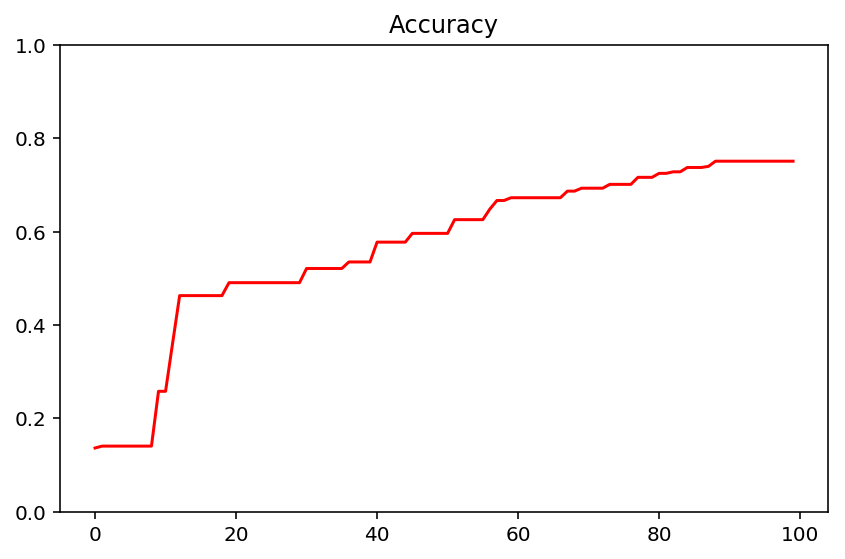

In [17]:
best_individ = execute(max_generations, population_size, mutation_rate)

## Test Model - MNIST

In [18]:
with tf.Session() as sess:
    net = Network(x_dim, 
                  n_classes,
                  best_individ.gene[0],
                  best_individ.gene[1], 
                  best_individ.gene[2], 
                  best_individ.gene[3])
    sess.run(tf.global_variables_initializer())

    values = []
    batch_num = mnist.test.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.test.next_batch(batch_size)
        # Run optimizers
        feed_dict = {net.x: train_batch,
                     net.y: labels}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.751102


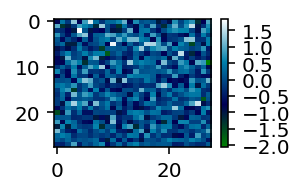

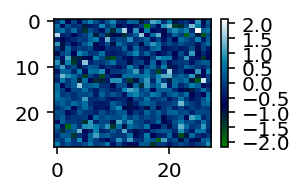

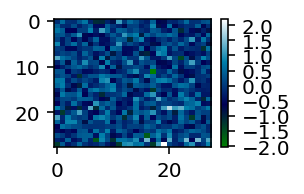

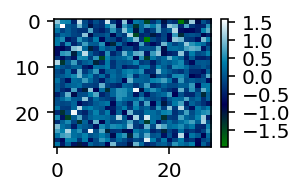

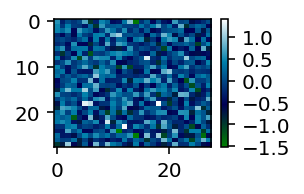

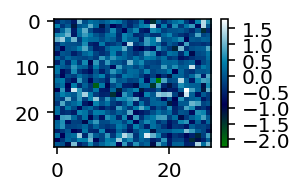

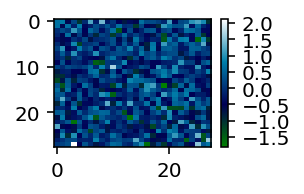

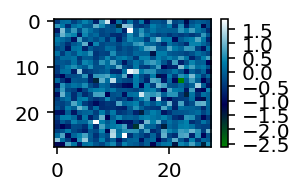

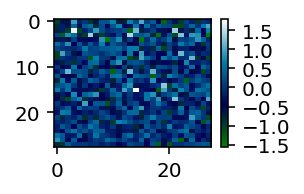

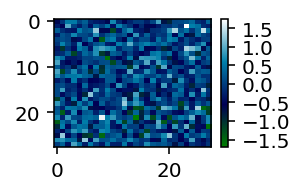

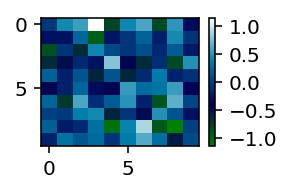

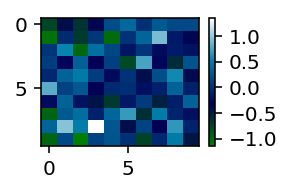

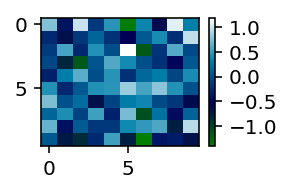

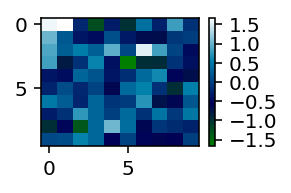

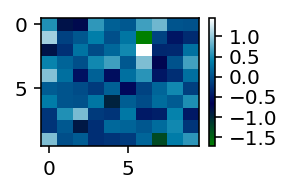

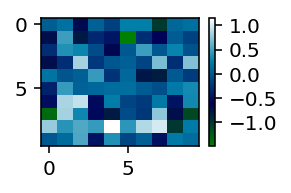

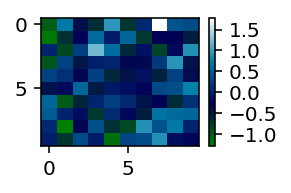

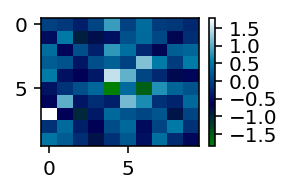

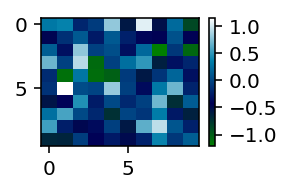

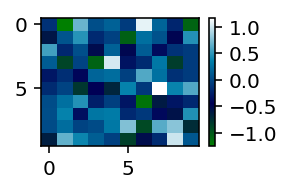

In [39]:
mat_a = np.reshape(best_individ.gene[0], (-1, 28, 28))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_a[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

mat_b = np.reshape(best_individ.gene[2], (-1, 10, 10))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_b[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

In [23]:
best_individ.gene[2]

array([[ -3.97842526e-02,   4.42336828e-01,   5.67361355e-01,
          1.15530932e+00,  -7.84469604e-01,   4.37624782e-01,
          6.16603255e-01,  -8.15170288e-01,   5.27278364e-01,
         -2.92347372e-01],
       [ -2.81485349e-01,  -2.55983949e-01,   2.49616265e-01,
         -9.39275384e-01,  -2.42555529e-01,  -4.46804538e-02,
          2.23369762e-01,  -1.88989729e-01,   4.53079760e-01,
         -5.08791655e-02],
       [ -8.39009225e-01,  -5.37170544e-02,  -6.25734091e-01,
          4.34788585e-01,   7.21185058e-02,  -4.36637402e-02,
          1.05061948e-01,  -1.26438767e-01,   1.82311922e-01,
         -2.10627854e-01],
       [ -6.37652397e-01,  -4.59401727e-01,  -1.13605618e-01,
         -2.53635764e-01,   7.93209791e-01,  -3.90813291e-01,
         -6.27288997e-01,  -9.39706266e-02,  -8.04364920e-01,
          5.02809525e-01],
       [  2.14780778e-01,  -1.70099184e-01,   1.39814913e-01,
         -5.80313325e-01,   1.38878763e-01,  -5.89156985e-01,
         -1.11521177e-01